# DIABETE PREDICTION





### Global Importation

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error,accuracy_score,confusion_matrix, classification_report
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# RN
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
#
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import GridSearchCV


### Global functions

In [11]:
def show_graphics(df:pd.DataFrame,target_col):
  variables = df.columns.to_list()
  variables.remove(target_col)

  plt.figure(figsize=(15, 5))
  #Changed the line below to iterate over variables instead of df.columns
  for i, var in enumerate(variables):
      plt.subplot(1, len(variables), i + 1)
      colors = ['blue' if d == 0 else 'red' for d in df[target_col]]
      plt.scatter(df[var], df[target_col], c=colors, alpha=0.7, edgecolor='k', s=100)
      plt.title(f"{var} vs {target_col}")
      plt.xlabel(var)
      plt.ylabel(target_col)
      plt.grid(True)

  plt.tight_layout()
  plt.show()

def show_corr_matrix(df:pd.DataFrame):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrice ")
    plt.show()

def plot_bar_and_pie(data:pd.DataFrame, column:str, figsize=(12, 6),bar_title="Repartition of ",pie_title="Repartition of "):
    """
    Affiche un graphique en barres et un camembert côte à côte
    pour une colonne donnée d'un DataFrame.

    Parameters:
    - data (DataFrame): Le DataFrame contenant les données.
    - column (str): Le nom de la colonne à analyser.
    - figsize (tuple): Taille de la figure (par défaut (12, 6)).
    """
    counts = data[column].value_counts()  # Comptage des valeurs

    # Création de la figure avec deux sous-graphiques
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Graphique en barres
    axes[0].bar(x=[str(x) for x in counts.index], height=counts)
    axes[0].set_title(f"{bar_title} {column} (Barres)")
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Total')

    # Graphique en camembert
    axes[1].pie(counts, labels=counts.index, autopct='%1.2f%%', explode=[0.2] + [0] * (len(counts) - 1))
    axes[1].set_title(f" {pie_title} {column} (Camembert)")

    # Ajustement des espaces
    plt.tight_layout()
    plt.show()


#Find the best one variable
def select_best_variable(data,target_col):
    data=data.copy(deep=True)
    r_squared = 0
    y_Y=data[target_col]
    data.drop(target_col,axis=1,inplace=True)
    for x in data.columns[2:] :
        X = data[x]  # Select the column containing the predictive variable
        X = sm.add_constant(X)  # add a constant column for the constant term of the model (for the parameter beta_0)
        Y = y_Y # Select the target varibale and store it in Y
        model1 = sm.OLS(Y,X).fit() # fit the model to predict Y using X
        if model1.rsquared > r_squared :
            r_squared = model1.rsquared
            m=model1
            x_best = x
    print("The best variable",x_best)
    return m.summary()

def select_best_variables_with_regression(data,target_col):
    data=data.copy(deep=True)
    # Séparer les variables dépendantes et indépendantes
    y = data[target_col]
    X = data.drop(target_col, axis=1)
    # Créer le modèle de régression linéaire
    regressor = LinearRegression()
    # Diviser les données en ensembles de formation et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # Sélectionner les variables les plus importantes
    selected_features = []
    for feature in X_train.columns:
        # Créer un sous-ensemble de variables
        features_subset = selected_features + [feature]

        # Entraîner le modèle sur le sous-ensemble de variables
        regressor.fit(X_train[features_subset], y_train)
        y_pred = regressor.predict(X_test[features_subset])

        # Calculer le R² ajusté pour le modèle
        r2 = r2_score(y_test, y_pred)
        adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - len(features_subset) - 1)

        # Ajouter la variable si le R² ajusté a augmenté
        if len(selected_features) == 0 or adj_r2 > max_r2:
            max_r2 = adj_r2
            best_feature = feature
        selected_features.append(best_feature)
    print("Variables sélectionnées : ", selected_features)
    return selected_features

#Modèles non linéaires
def add_polynomial_feature(data1, idx_p, power):
    new_data = data1.copy(deep = True)
    # print("len::",len(idx_p))
    for i in range(0, len(idx_p)):
        for j in power:
            for k in range(2, j+1):
                new_data['{}_pow_{}'.format(idx_p[i],k)] = new_data.loc[:,idx_p[i]]**k
    return (new_data)

# Multiple regression
def multiple_regression(data,target_col):
    data=data.copy(deep=True)
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    X = sm.add_constant(X)
    Y = data[target_col]
    model = sm.OLS(Y,X).fit()
    return model.summary()

# VIF verrification
def verify_vif(data,target_col):
    data=data.copy(deep=True)
    X = data.drop(target_col, axis=1)
    X = sm.add_constant(X)  # Ajoute l'intercept

    # Calcul du VIF pour chaque feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data


# Select feature with Random Forest
def feature_selection_with_rf(data, target, n_features=10, n_estimators=100, random_state=42):
    # Séparer les features et la cible
    X = data.drop(columns=[target])
    y = data[target]

    # Diviser les données en train, validation et test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

    # Initialiser le Random Forest
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

    # Entraîner le modèle
    rf.fit(X_train, y_train)

    # Prédictions et évaluation sur l'ensemble de validation
    y_val_pred = rf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f'Accuracy on validation set: {val_accuracy:.4f}')

    # Prédictions et évaluation sur l'ensemble de test
    y_test_pred = rf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Accuracy on test set: {test_accuracy:.4f}')

    # Importance des features
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Afficher les features les plus importantes
    print(feature_importances.head(n_features))

    # Sélectionner les meilleures features
    selected_features = feature_importances.head(n_features)['Feature'].tolist()

    return selected_features



#### 0. Load data

In [15]:
df=pd.read_csv("/home/peyanan/Diabete_prediction/TAIPEI_diabetes.csv",delimiter=",")

In [16]:
df.head(10)

PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
0    1354778            0            171                      80   
1    1147438            8             92                      93   
2    1640031            7            115                      47   
3    1883350            9            103                      78   
4    1424119            1             85                      59   
5    1619297            0             82                      92   
6    1660149            0            133                      47   
7    1458769            0             67                      87   
8    1201647            8             80                      95   
9    1403912            1             72                      31   

   TricepsThickness  SerumInsulin        BMI  DiabetesPedigree  Age  Diabetic  
0                34            23  43.509726          1.213191   21         0  
1                47            36  21.240576          0.158365   23         0  
2                52            35  41.511523          0.079019   23         0  
3                25           304  29.582192          1.282870   43         1  
4                27            35  42.604536          0.549542   22         0  
5                 9           253  19.724160          0.103424   26         0  
6                19           227  21.941357          0.174160   21         0  
7                43            36  18.277723          0.236165   26         0  
8                33            24  26.624929          0.443947   53         1  
9                40            42  36.889576          0.103944   26         0

# 1. Data comprehension

### 1.1 Data size

In [17]:
# Data size
df.shape

(15000, 10)

##### NB: According data set size,we get:
   - 15K rows
   - 10 columns


#### 1.2. Columns's type analysis

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


#### NB 1.2: Accord this part, there are two  types of columns:
- Integer: All columns except  BMI and DiabetesPedigree
- Float:BMI,DiabetesPedigree
- Type base: 64

We can also mark, there are no missing value because we are the same size with our original data set. Howover, we have to verify with another Method in the step.

#### 1.3 A few statistics

In [19]:
# Analyzing descriptive statistics
df.describe()

PatientID   Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
count  1.500000e+04  15000.000000   15000.000000            15000.000000   
mean   1.502922e+06      3.224533     107.856867               71.220667   
std    2.892534e+05      3.391020      31.981975               16.758716   
min    1.000038e+06      0.000000      44.000000               24.000000   
25%    1.252866e+06      0.000000      84.000000               58.000000   
50%    1.505508e+06      2.000000     104.000000               72.000000   
75%    1.755205e+06      6.000000     129.000000               85.000000   
max    1.999997e+06     14.000000     192.000000              117.000000   

       TricepsThickness  SerumInsulin           BMI  DiabetesPedigree  \
count      15000.000000  15000.000000  15000.000000      15000.000000   
mean          28.814000    137.852133     31.509646          0.398968   
std           14.555716    133.068252      9.759000          0.377944   
min            7.000000     14.000000     18.200512          0.078044   
25%           15.000000     39.000000     21.259887          0.137743   
50%           31.000000     83.000000     31.767940          0.200297   
75%           41.000000    195.000000     39.259692          0.616285   
max           93.000000    799.000000     56.034628          2.301594   

                Age      Diabetic  
count  15000.000000  15000.000000  
mean      30.137733      0.333333  
std       12.089703      0.471420  
min       21.000000      0.000000  
25%       22.000000      0.000000  
50%       24.000000      0.000000  
75%       35.000000      1.000000  
max       77.000000      1.000000

In [20]:
# Show if we have missing data.
messing=f"isna:{df.isna().sum()}  \n|============================================| \n isnull:{df.isnull().sum()}"
print(messing)

isna:PatientID                 0
Pregnancies               0
PlasmaGlucose             0
DiastolicBloodPressure    0
TricepsThickness          0
SerumInsulin              0
BMI                       0
DiabetesPedigree          0
Age                       0
Diabetic                  0
dtype: int64  
|============================================| 
 isnull:PatientID                 0
Pregnancies               0
PlasmaGlucose             0
DiastolicBloodPressure    0
TricepsThickness          0
SerumInsulin              0
BMI                       0
DiabetesPedigree          0
Age                       0
Diabetic                  0
dtype: int64


In [21]:
# Show number of diabetes diagnosed in our data dataset
diagnosed=df['Diabetic'].value_counts()
diagnosed_percentage = df['Diabetic'].value_counts(normalize=True) * 100
print("Diagnosed:",diagnosed)
print("Percentage:",diagnosed_percentage)

Diagnosed: Diabetic
0    10000
1     5000
Name: count, dtype: int64
Percentage: Diabetic
0    66.666667
1    33.333333
Name: proportion, dtype: float64


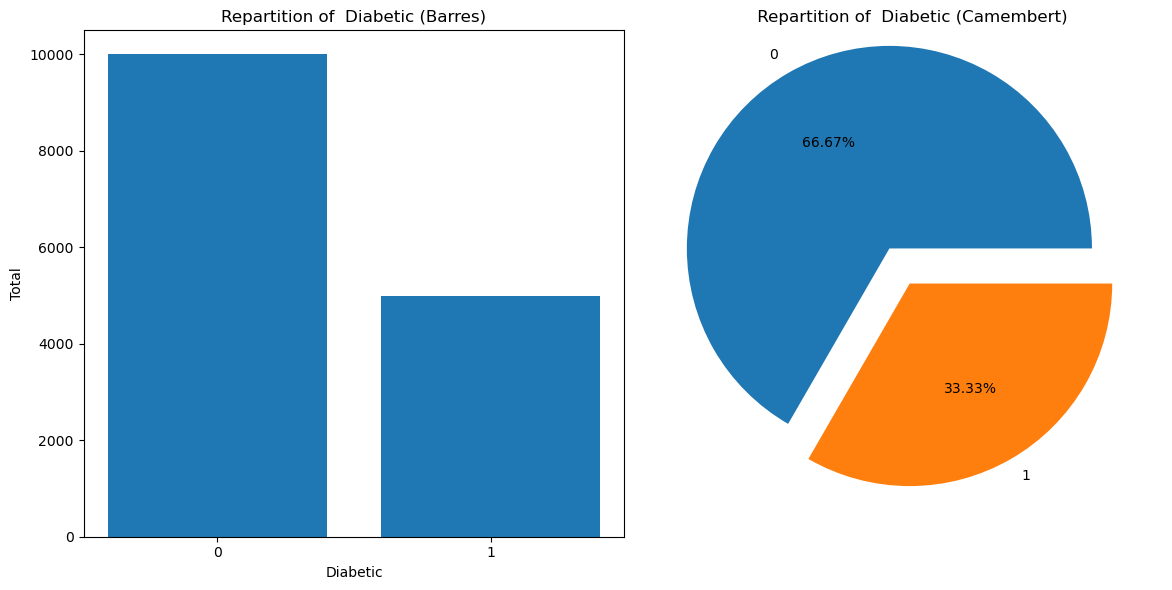

In [22]:
plot_bar_and_pie(df,"Diabetic")

    NB:
     - Looking at these statistics, no data is missing. Moreover, there is no categorical data.
     - In this data set, 33,33% either 5k persons have a diabete again 66,33% either 10k no diagnosed diabestic.
     

## 2. Analyzing of data features
- PatientID :Is a patient identifier.
- Pregnancies:Number of times pregnant.
- PlasmaGlucose: Plasma glucose concentration after 2 hours in an oral glucose tolerance test.
- DiastolicBloodPressure:A function that scores the probability of diabetes based on family history.
- TricepsThickness:Triceps skin fold thickness (mm).
- SerumInsulin:2-Hour serum insulin (mu U/ml).
- BMI: Body mass index (weight in kg/(height in m)^2).
- DiabetesPedigree:A function that scores the probability of diabetes based on family history.
- Age:Age in years the species.
- Diabetic:Is the truth, the goal for Prediction.

### 2.1. Visualization of the point cloud.
#### A. Show a relationship between each feature with our target and catch outlier as possible.

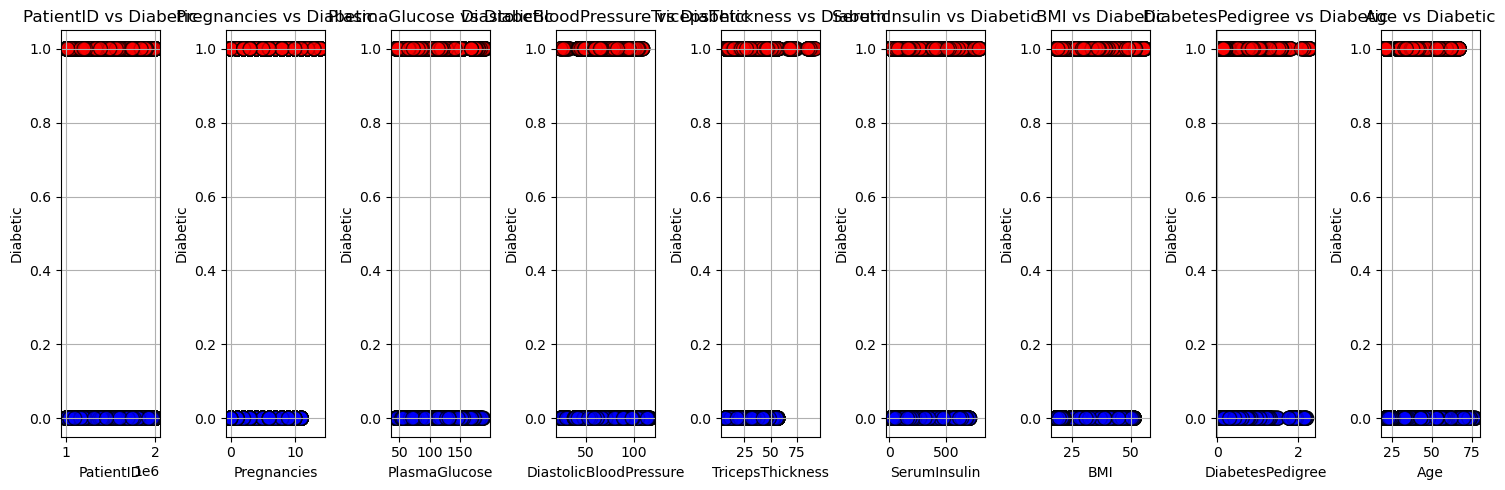

In [23]:
show_graphics(df,'Diabetic')

 #### B. Show a relationship between each feature with our target spliting by cluster (0 and 1) and catch outlier as possible.

In [24]:
no_diabete_df=df[df['Diabetic']==0]
diabete_df=df[df['Diabetic']==1]

###### - No diabete cloud points

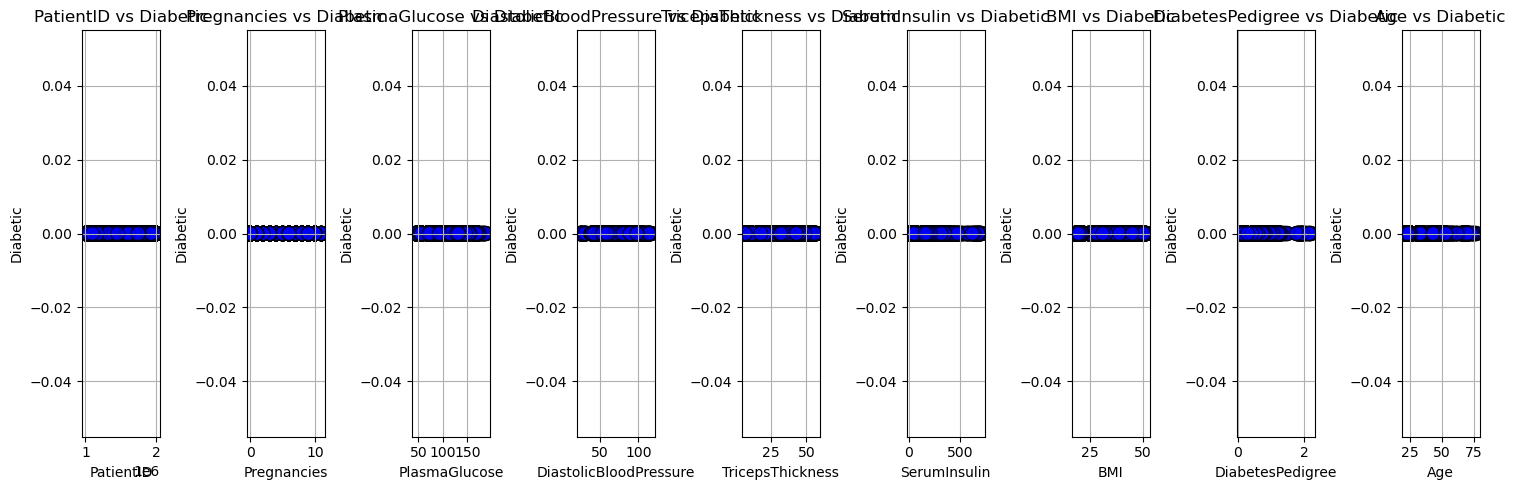

In [25]:
show_graphics(no_diabete_df,'Diabetic')

###### - Diabete cloud points

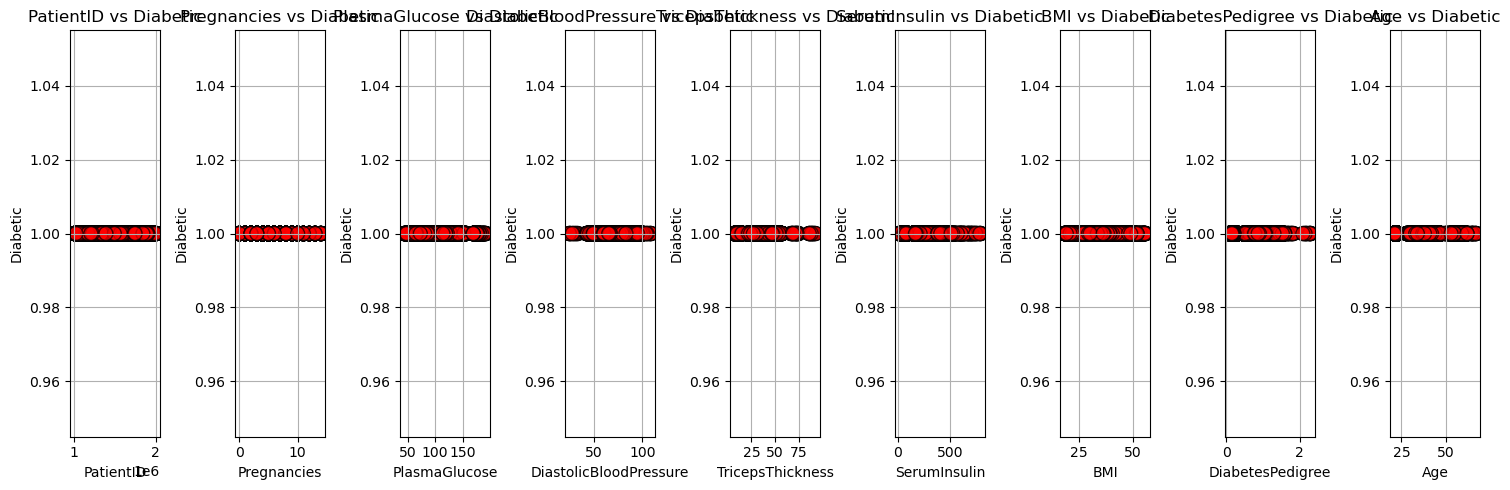

In [26]:
show_graphics(diabete_df,'Diabetic')

##### Distribution of each feature

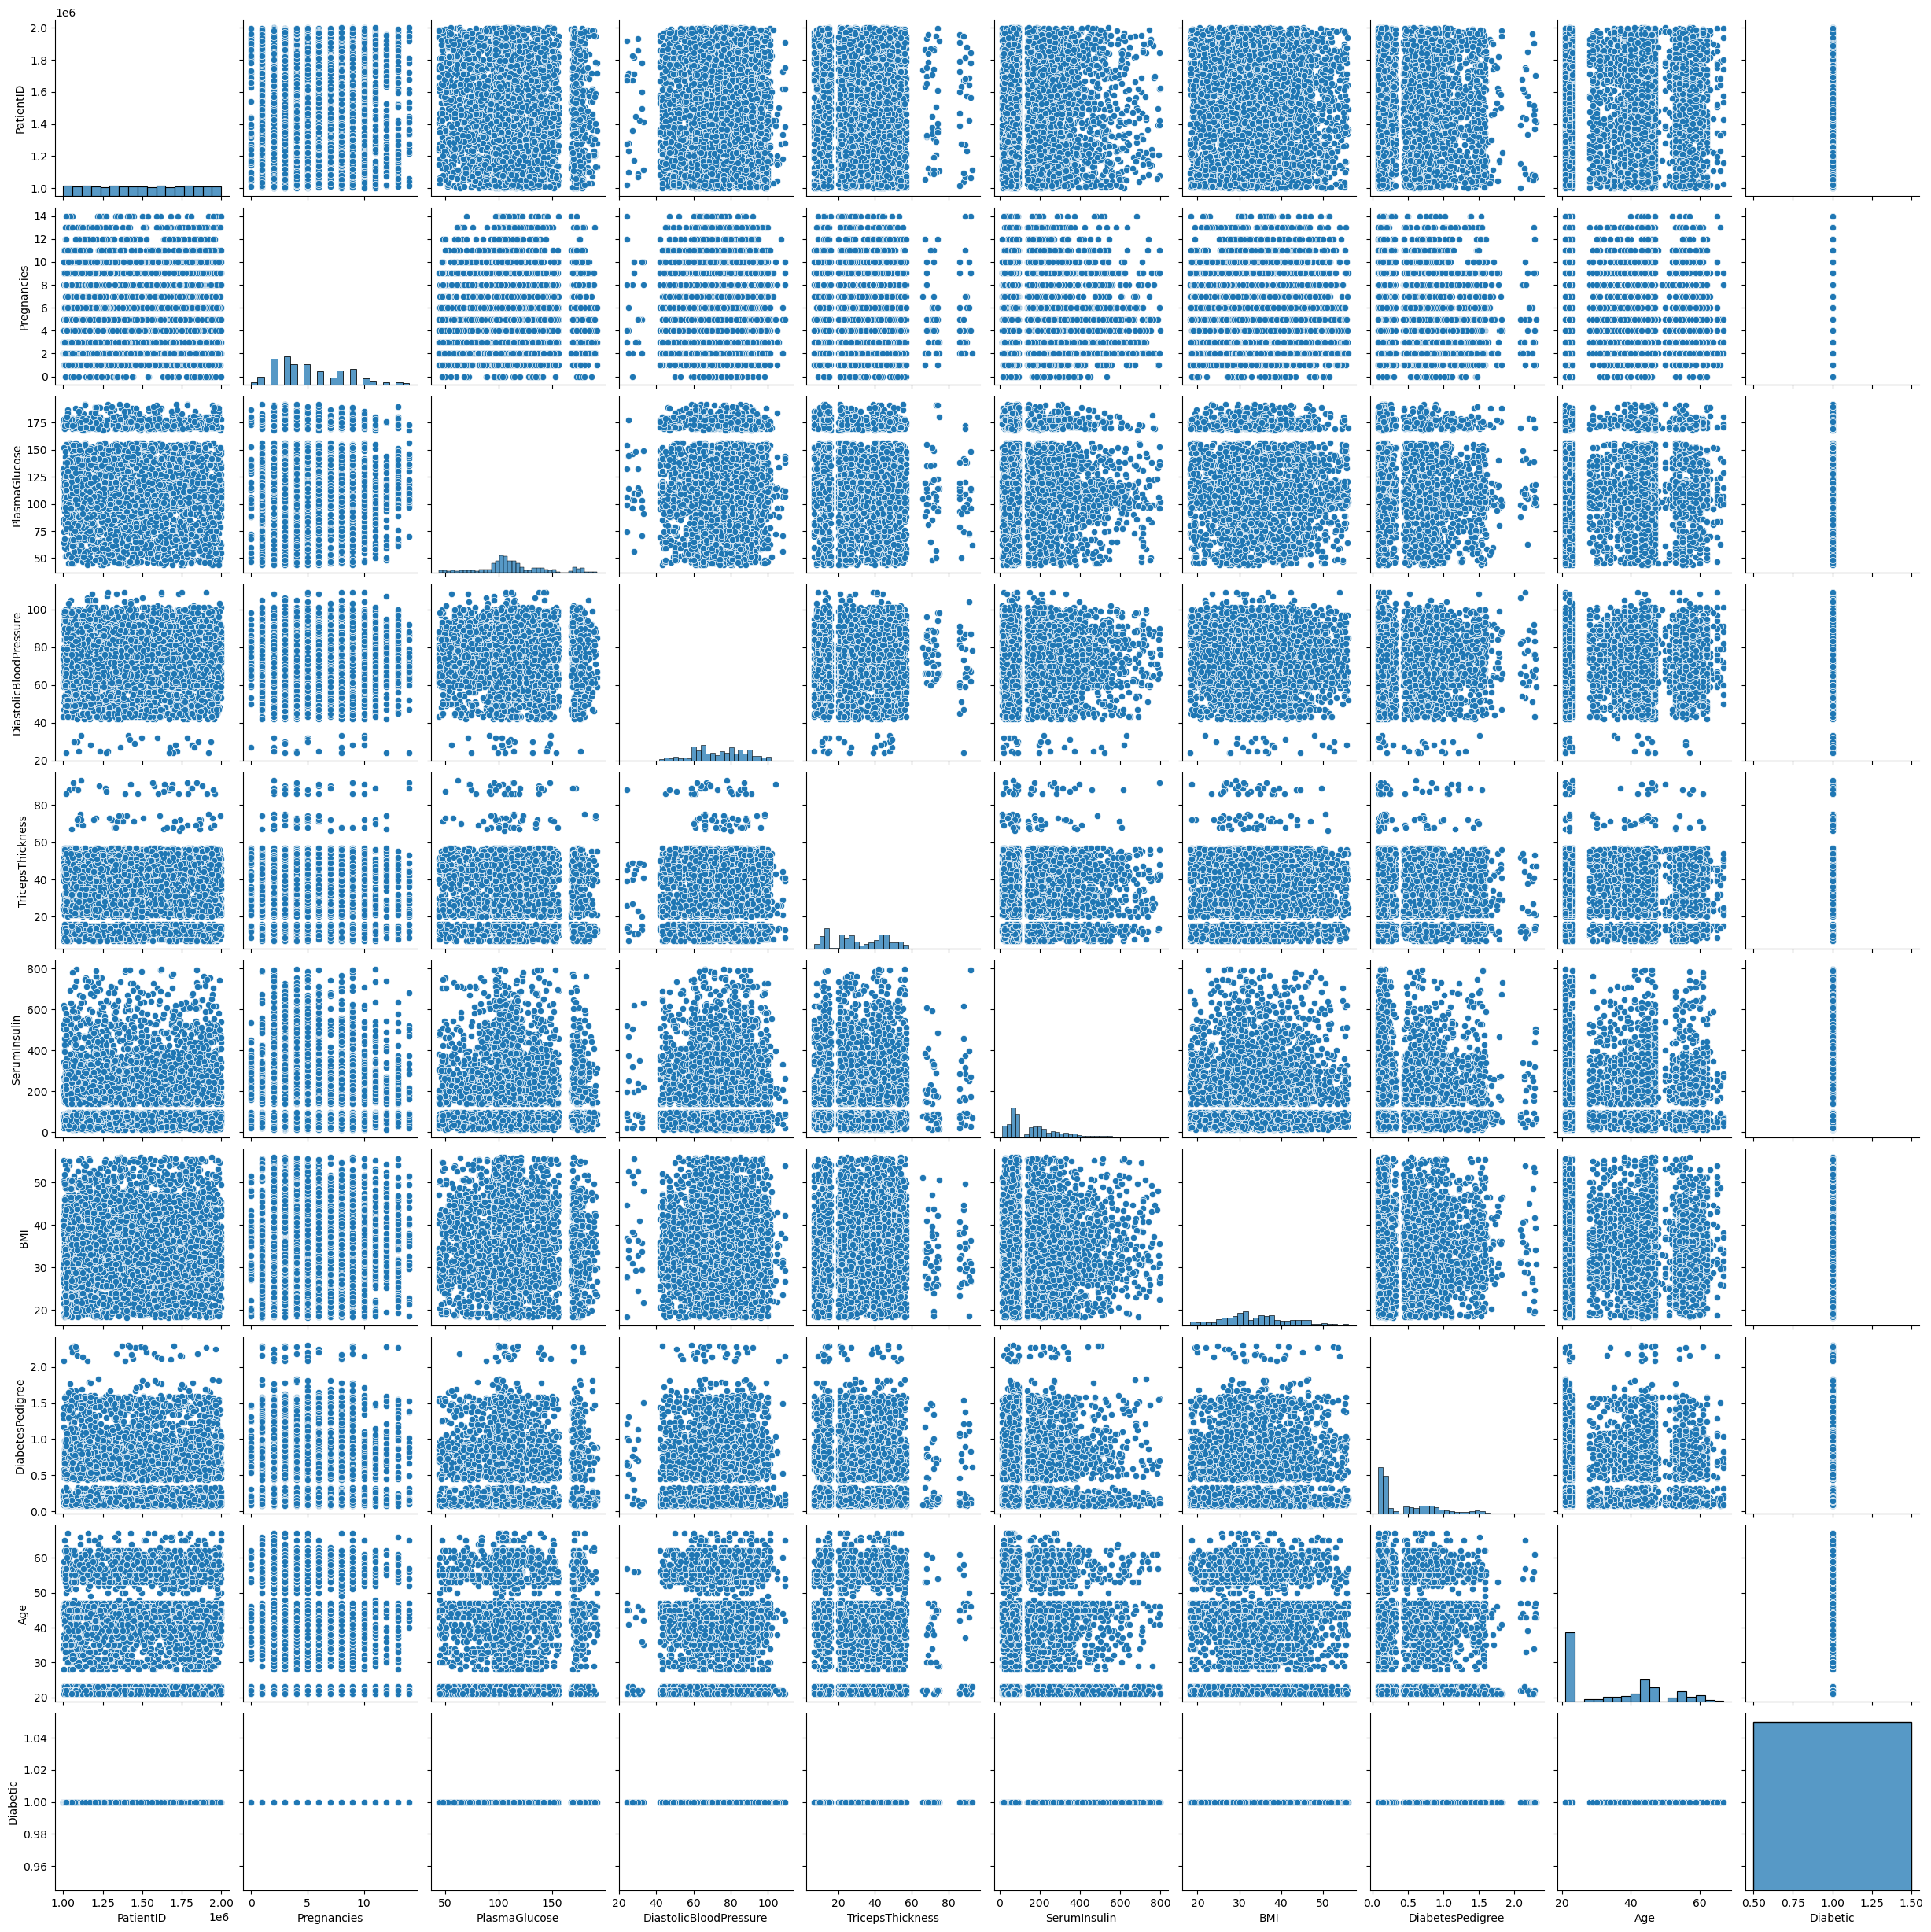

In [27]:
sns.pairplot(diabete_df)
plt.show()

#### C. Feature relationship with correlation

##### - All cluster (0 and 1) correlation.

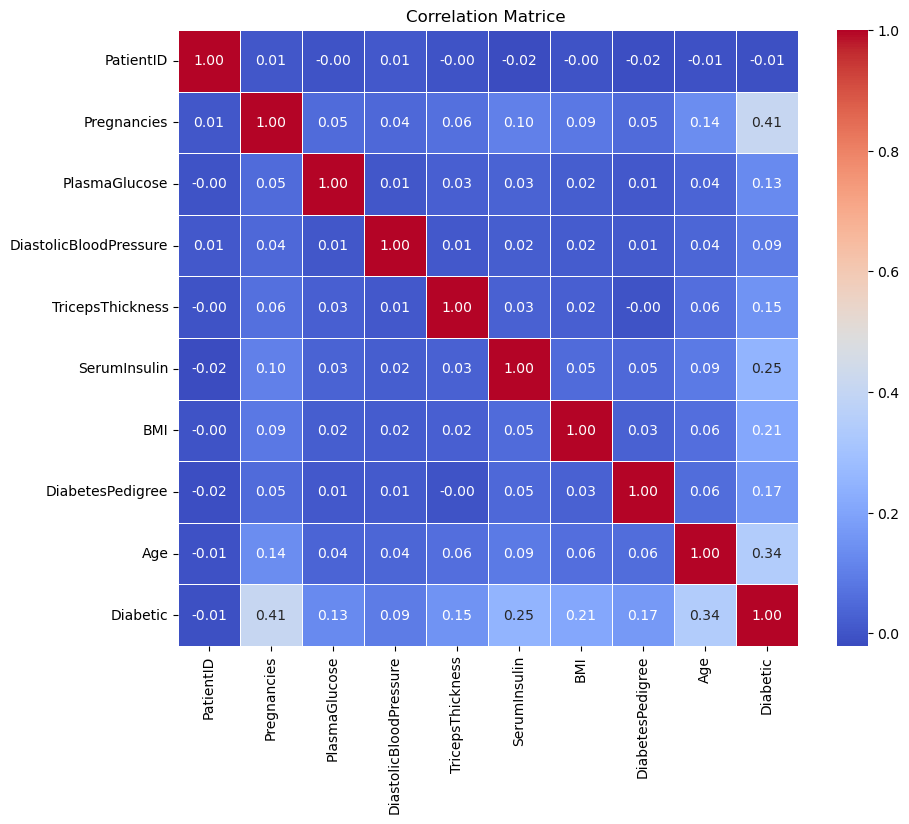

In [28]:
# correlation_matrix = df.corr()
# print(correlation_matrix)
# Corr
show_corr_matrix(df)

##### - Cluster (0 ) correlation.

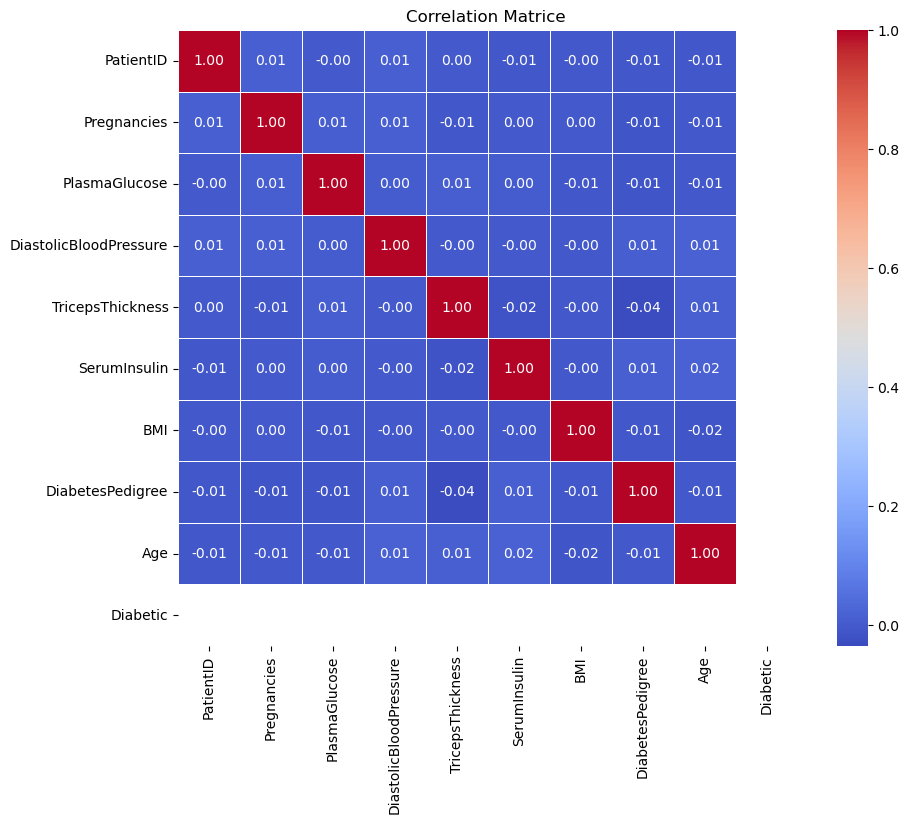

In [29]:
show_corr_matrix(no_diabete_df)

##### - Cluster (1 ) correlation.

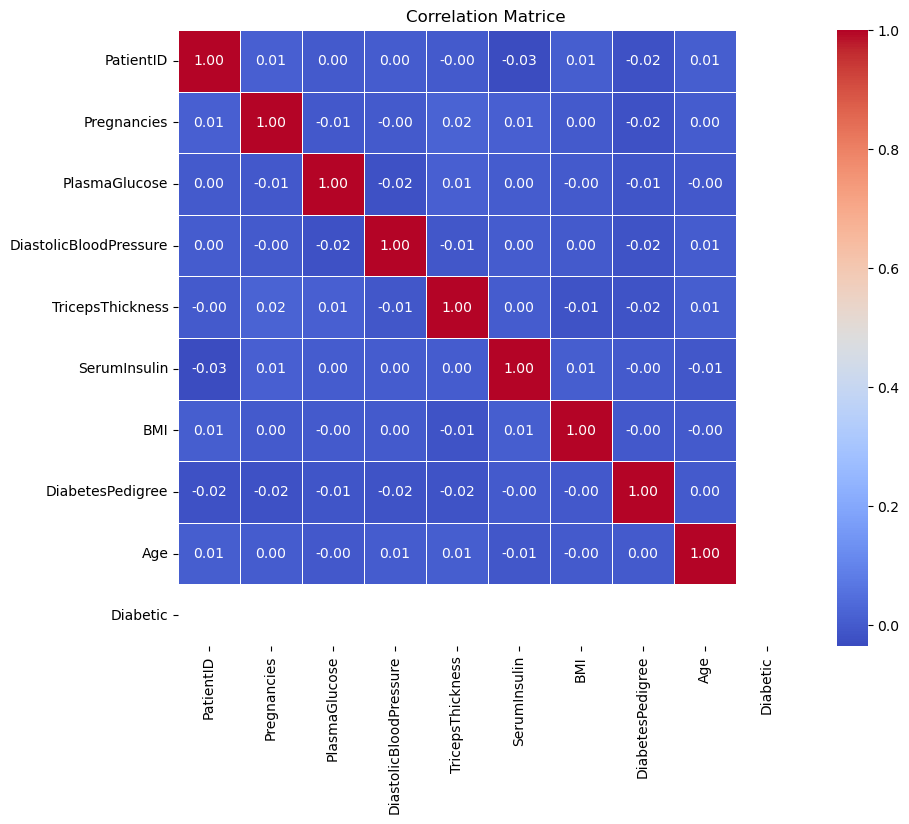

In [30]:
show_corr_matrix(diabete_df)

### NB-RESUME:
In summary, after this analysis, it is clear that the “PatientID” variable is of no use in our study. Furthermore, the correlations with the target are generally very weak, with the exception of that with the “Pregnancies” variable. This low or non-existent correlation clearly indicates that our variables are independent of each other. This eliminates the need for a **Decorrelation** step through dimension reduction techniques, such as PCA or PCA.

This leads us to formulate the following hypotheses:

- All variables, with the exception of “PatientID”, contribute to the explanation of the target variable “Diabetic”.
  
- The variable “Pregnancies”, which shows the strongest correlation with “Diabetic”, seems to play a significant role in explaining the target.

- The “PlasmaGlucose”, “BMI” and “Age” variables are strongly linked to known metabolic factors. They could have a significant influence on “Diabetic”, although their direct correlations are weak.

- The variables “PatientID” and “DiastolicBloodPressure” provide no significant information to explain “Diabetic” and can be excluded without affecting model performance.

Note: In order to validate these hypotheses, statistical tests will be carried out to select the relevant variables, then a series of models will be created to choose the one offering the best performance.


### 2-1 ) Features selections

* ##### 1-) Linear selection





In [31]:
best_variable=select_best_variable(df,"Diabetic")

The best variable Age


In [32]:
df.columns

Index(['PatientID', 'Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
       'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age',
       'Diabetic'],
      dtype='object')

In [33]:
best_variables=select_best_variables_with_regression(df,"Diabetic")

Variables sélectionnées :  ['PatientID', 'Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']


> ####   Multiple regression for linear





In [34]:
summary=multiple_regression(df,"Diabetic")
print(summary)

                            OLS Regression Results                            
Dep. Variable:               Diabetic   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     879.0
Date:                Wed, 12 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:06:20   Log-Likelihood:                -6825.0
No. Observations:               15000   AIC:                         1.367e+04
Df Residuals:                   14990   BIC:                         1.375e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

#### Conclusion for linear feature selection:
As we can see above ,

*About the model quality :*
- **R=0.345**, This model explain only 34,5% of the variance of the target variable (“Diabetic”).So more than 70% diabetic case is not explain.
- F-statistic = 694.7, Prob (F-statistic) = 0.00 : The overall model is significant, so at least one of the explanatory variables has an effect on the target variable(“Diabetic”).

*About a feature:* All of them is significant except patientID because we have **(P>|t| < 0.05)**  for  *Pregnancies, PlasmaGlucose, DiastolicBloodPressure, TricepsThickness, SerumInsulin, BMI, DiabetesPedigree and Age.*

According to the Diagnostics ,**Cond. No. = 1.32e+07**: This number is very high, potentially suggesting collinearity problems between the independent variables.. Il faudrait vérifier la matrice de corrélation ou utiliser des outils comme le VIF (Variance Inflation Factor).
As this explain only 34% of diabetic case, we will test others strategies

* ##### Best features Using polinomial feature

#### Mutiple regression for polinomial feature

In [35]:
col=df.columns.to_list()
col.remove('Diabetic')
train_poly = add_polynomial_feature(df,col,[2])



In [36]:
print(train_poly.columns)

Index(['PatientID', 'Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
       'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age',
       'Diabetic', 'PatientID_pow_2', 'Pregnancies_pow_2',
       'PlasmaGlucose_pow_2', 'DiastolicBloodPressure_pow_2',
       'TricepsThickness_pow_2', 'SerumInsulin_pow_2', 'BMI_pow_2',
       'DiabetesPedigree_pow_2', 'Age_pow_2'],
      dtype='object')


In [37]:
summary=multiple_regression(train_poly,"Diabetic")
print(summary)

                            OLS Regression Results                            
Dep. Variable:               Diabetic   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     623.8
Date:                Wed, 12 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:06:20   Log-Likelihood:                -5808.3
No. Observations:               15000   AIC:                         1.165e+04
Df Residuals:                   14981   BIC:                         1.180e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

#### Conclusion for polinomiale feature
R² = 0.428, Adj. R² = 0.428: This mean this model explain 42% of the diabetic. It less better than the other above.

Cond. No.(Condition Number) = 9.66e+13: This number is huge, so it's a strong indication of collinearity between variables, especially with the addition of polynomial terms. So the decree 2 polynomial is too much, so the best model is a simple one, which we'll look at next.

#### Verification of VIF(Variance Inflation Factor

 #### Cleaning

In [38]:
# cleaning data:PatientID will be removed
df_cleaned=df.drop('PatientID',axis=1)

In [39]:
vif_data =verify_vif(df_cleaned,"Diabetic")
print(vif_data.sort_values(by="VIF", ascending=False))

                  Feature        VIF
0                   const  47.373366
1             Pregnancies   1.041960
8                     Age   1.033993
5            SerumInsulin   1.020842
6                     BMI   1.012699
4        TricepsThickness   1.008115
7        DiabetesPedigree   1.007335
2           PlasmaGlucose   1.005320
3  DiastolicBloodPressure   1.003652


#### **Note VIF:**
All the VIFs are very low (around 1), meaning that there is no problematic collinearity between the variables.

#### Feature selection with random forest

In [40]:
#feature selection test
selected_features = feature_selection_with_rf(df_cleaned, 'Diabetic', n_features=10)
print("Features sélectionnées:", selected_features)

Accuracy on validation set: 0.9329
Accuracy on test set: 0.9338
                  Feature  Importance
0             Pregnancies    0.296301
7                     Age    0.172709
5                     BMI    0.164595
4            SerumInsulin    0.118738
1           PlasmaGlucose    0.095368
3        TricepsThickness    0.056577
2  DiastolicBloodPressure    0.050835
6        DiabetesPedigree    0.044877
Features sélectionnées: ['Pregnancies', 'Age', 'BMI', 'SerumInsulin', 'PlasmaGlucose', 'TricepsThickness', 'DiastolicBloodPressure', 'DiabetesPedigree']


In [41]:
# with polynomial case
selected_features = feature_selection_with_rf(train_poly, 'Diabetic', n_features=10)
print("Features sélectionnées:", selected_features)

Accuracy on validation set: 0.9298
Accuracy on test set: 0.9298
                Feature  Importance
10    Pregnancies_pow_2    0.179629
1           Pregnancies    0.165705
17            Age_pow_2    0.086072
6                   BMI    0.083436
8                   Age    0.083199
15            BMI_pow_2    0.077615
14   SerumInsulin_pow_2    0.056188
5          SerumInsulin    0.049178
2         PlasmaGlucose    0.039526
11  PlasmaGlucose_pow_2    0.037754
Features sélectionnées: ['Pregnancies_pow_2', 'Pregnancies', 'Age_pow_2', 'BMI', 'Age', 'BMI_pow_2', 'SerumInsulin_pow_2', 'SerumInsulin', 'PlasmaGlucose', 'PlasmaGlucose_pow_2']


### Conclusion Part 2:
The significant features of this dataset for diabetic diagnosis are Pregnancies, Age, BMI, SerumInsulin, PlasmaGlucose, TricepsThickness, DiastolicBloodPressure, and DiabetesPedigree. However, Pregnancies, Age, BMI, and SerumInsulin are more significant than the others.
We note that the polynomial feature is not significant as can see in his accurancy of test dataset. That say, the model explain less than 50% of the population (target feature: diabetic).

## 3. Data Prediction

#### 3.1. Spliting data set

In [42]:
# Initial division: training (70%) and temporary set (40%)
train_set, temp_set, train_labels, temp_labels = train_test_split(
    df_cleaned[['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
                'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']],
    df_cleaned['Diabetic'],
    test_size=0.3,  # 30% for test + validation
    random_state=42
)

# Division of temporary set: validation (50% of temporary set) and testing (50% of temporary set)
validation_set, test_set, validation_labels, test_labels = train_test_split(
    temp_set,
    temp_labels,
    test_size=0.5,  # 50% for  temporaire set
    random_state=42
)



In [43]:
# Displaying set sizes
print("Size of train set :", train_set.shape)
print("Size of validation set:", validation_set.shape)
print("Size of test set:", test_set.shape)

Size of train set : (10500, 8)
Size of validation set: (2250, 8)
Size of test set: (2250, 8)


In [44]:
# Verification of spliting size
train_set_percentage=train_set.shape[0]/df_cleaned.shape[0]
test_set_percentage=test_set.shape[0]/df_cleaned.shape[0]
validation_set_percentage=validation_set.shape[0]/df_cleaned.shape[0]
print(f"train_set_percentage:{train_set_percentage} \ntest_set_percentage:{test_set_percentage} \nvalidation_set_percentage:{validation_set_percentage}")

train_set_percentage:0.7 
test_set_percentage:0.15 
validation_set_percentage:0.15


In [45]:
# validation_labels
test_labels

8602     0
438      0
8094     0
14355    1
8581     1
        ..
3409     0
6973     1
708      0
3351     1
2142     1
Name: Diabetic, Length: 2250, dtype: int64

#### 3.2. Models Creation

**What task do we have to perform? This is a suppervised task**





#### Case 1: Linear regression

In [46]:
# Linear regression model initialization
linear_model = LinearRegression()
# Model training
linear_model.fit(train_set, train_labels)
# Prédictions of the  validation set
validation_predictions = linear_model.predict(validation_set)
test_predictions = linear_model.predict(test_set)
# Model evaluation
mse = mean_squared_error(validation_labels, validation_predictions)
r2 = r2_score(validation_labels, validation_predictions)
# test case
mse_test = mean_squared_error(test_labels, test_predictions)
r2_test = r2_score(validation_labels, validation_predictions)
# Outcomes
print("Model coefficients :", linear_model.coef_)
print("Ordinate at origin :", linear_model.intercept_)
print("Mean square error (MSE) on the validation set :", mse)
print("R² score on validation set :", r2)

print("Mean square error (MSE) on the test set :", mse_test)
print("R² score on test set :", r2_test)


Model coefficients : [0.0442964  0.00127457 0.00138088 0.00339714 0.00062978 0.0066761
 0.15617054 0.0099289 ]
Ordinate at origin : -0.8038003713960418
Mean square error (MSE) on the validation set : 0.1489435251552441
R² score on validation set : 0.3411858794216768
Mean square error (MSE) on the test set : 0.14278585741240907
R² score on test set : 0.3411858794216768


#### **Conclusion case 1** :  

---

Looking at this result, the linear regression model explains **34%** of the data set R^2 = 0.34. This leaves more than **60%** of diabetes cases unexplained. What's more, of the **34%** explained, the model makes an average of **14%** errors.  

So, to improve this model, we'd need more data, which we don't have. We will therefore test other models.   




#### Case 2: Logistic regression

In [47]:
# Initialization of the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Training the model on the training set
logistic_model.fit(train_set, train_labels)

# Predictions on the validation set and test set
validation_predictions = logistic_model.predict(validation_set)
test_predictions = logistic_model.predict(test_set)

# Model evaluation on validation set
accuracy = accuracy_score(validation_labels, validation_predictions)
conf_matrix = confusion_matrix(validation_labels, validation_predictions)
class_report = classification_report(validation_labels, validation_predictions)

# Model evaluation on test set
accuracy_test = accuracy_score(test_labels, test_predictions)
conf_matrix_test = confusion_matrix(test_labels, test_predictions)
class_report_test = classification_report(test_labels, test_predictions)

# Displaying results for validation set
print("Accuracy on the validation set:", accuracy)
print("\nConfusion matrix:\n", conf_matrix)
print("\nClassification report:\n", class_report)

# Displaying results for test set
print("Accuracy on the test set:", accuracy_test)
print("\nConfusion matrix:\n", conf_matrix_test)
print("\nClassification report:\n", class_report_test)





Accuracy on the validation set: 0.7795555555555556

Confusion matrix:
 [[1319  154]
 [ 342  435]]

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84      1473
           1       0.74      0.56      0.64       777

    accuracy                           0.78      2250
   macro avg       0.77      0.73      0.74      2250
weighted avg       0.77      0.78      0.77      2250

Accuracy on the test set: 0.7915555555555556

Confusion matrix:
 [[1365  167]
 [ 302  416]]

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85      1532
           1       0.71      0.58      0.64       718

    accuracy                           0.79      2250
   macro avg       0.77      0.74      0.75      2250
weighted avg       0.79      0.79      0.79      2250



#### **Conclusion Cas 2**:
---
Rappel Matrice de confusion:

|               | Prédiction: Positif | Prédiction: Négatif |
|--------------|--------------------|--------------------|
| **Réel: Positif**  | Vrai Positif (VP)  | Faux Négatif (FN)  |
| **Réel: Négatif**  | Faux Positif (FP)  | Vrai Négatif (VN)  |


1.  Precision=VN/(VP +FP):
- Plus elle est élevé, plus le modèle de Machine Learning minimise le nombre de Faux Positif.
- Quand la précision est haute, cela veut dire que la majorité des prédictions positives du modèle sont des positifs bien prédit.

2. recall=VP/(VP +FN):
- Plus il est élevé, plus le modèle de Machine Learning maximise le nombre de Vrai Positif.

**Mais attention**, cela ne veut pas dire que le modèle ne se trompe pas.

- Quand le recall est haut, cela veut plutôt dire qu’il ne ratera aucun positif. Néanmoins cela ne donne aucune information sur sa qualité de prédiction sur les négatifs.
3. F1 Score=2*(recall**precision /(recall+precision)) :
- Plus le F1 Score est élevé, plus le modèle est performant.

**Source:** https://inside-machinelearning.com/recall-precision-f1-score/

---
En analysant le rapport de ce résultat, nous obtenons un **recall de 78%**, une **précision de 78 %** ,f1-score **77%** et un **taux de vérités de 78 %**, laissant **32 % des cas non expliqués**.  

Par conséquent, ce modèle ne semble pas adapté pour prédire les cas de diabète.


Case 3: Decision tree

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

Accuracy on the validation set: 0.8977777777777778

Confusion matrix:
 [[1345  128]
 [ 102  675]]

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      1473
           1       0.84      0.87      0.85       777

    accuracy                           0.90      2250
   macro avg       0.89      0.89      0.89      2250
weighted avg       0.90      0.90      0.90      2250

Accuracy on the test set: 0.888

Confusion matrix:
 [[1371  161]
 [  91  627]]

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92      1532
           1       0.80      0.87      0.83       718

    accuracy                           0.89      2250
   macro avg       0.87      0.88      0.87      2250
weighted avg       0.89      0.89      0.89      2250



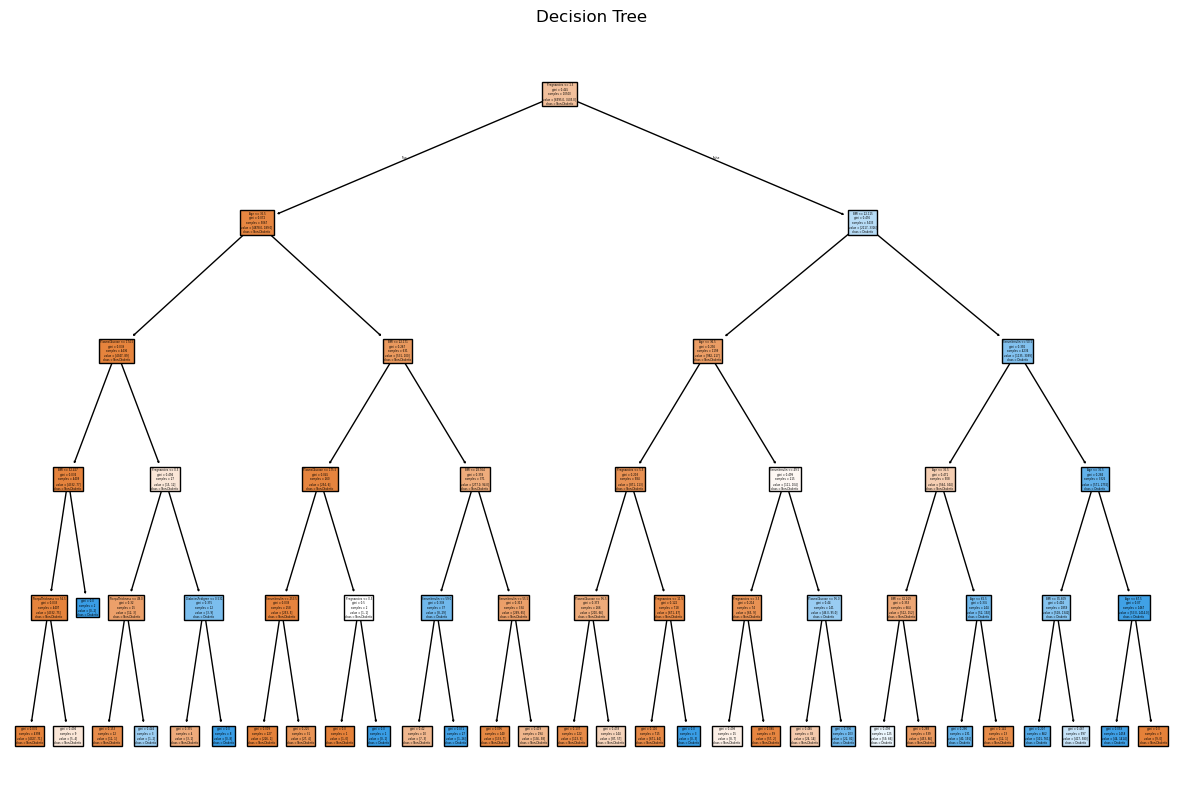

In [49]:
# Initialization of the decision tree model
decision_tree_model = DecisionTreeClassifier(random_state=42, max_depth=5)

# Training the model on the training set
decision_tree_model.fit(train_set, train_labels)

# Predictions on the validation and test sets
validation_predictions = decision_tree_model.predict(validation_set)
test_predictions = decision_tree_model.predict(test_set)

# Model evaluation on the validation set
accuracy = accuracy_score(validation_labels, validation_predictions)
conf_matrix = confusion_matrix(validation_labels, validation_predictions)
class_report = classification_report(validation_labels, validation_predictions)

# Model evaluation on the test set
accuracy_test = accuracy_score(test_labels, test_predictions)
conf_matrix_test = confusion_matrix(test_labels, test_predictions)
class_report_test = classification_report(test_labels, test_predictions)

# Displaying results for the validation set
print("Accuracy on the validation set:", accuracy)
print("\nConfusion matrix:\n", conf_matrix)
print("\nClassification report:\n", class_report)

# Displaying results for the test set
print("Accuracy on the test set:", accuracy_test)
print("\nConfusion matrix:\n", conf_matrix_test)
print("\nClassification report:\n", class_report_test)

# Visualization of the decision tree
plt.figure(figsize=(15, 10))
plot_tree(decision_tree_model, feature_names=train_set.columns, class_names=['Non-Diabetic', 'Diabetic'], filled=True)
plt.title("Decision Tree")
plt.show()



Conclusion cas 3:
En analysant le rapport de ce résultat, nous obtenons un **recall de 90%**, une **précision de 90 %** ,f1-score **90%** , laissant **10 % des cas non expliqués**.  

Par conséquent, ce modèle  semble pas adapté pour prédire les cas de diabète.



Cas 4: SVM

In [50]:
def evaluate_svm_kernels(train_set, train_labels,validation_set,validation_labels, kernels=['linear', 'rbf', 'poly', 'sigmoid'], C_values=0.1):
    """
    Boucle sur différents noyaux SVM et valeurs de C, puis stocke les résultats dans un DataFrame.

    Args:
        X (array): Features
        y (array): Target labels
        z (array): Validation labels
        w (array): Validation set
        kernels (list): Liste des noyaux à tester
        C_values (list): Liste des valeurs de C à tester

    Returns:
        pd.DataFrame: DataFrame avec accuracy, kernel et valeur de C
    """
    results = []

    # Séparer les données en ensemble d'entraînement et de test
    # Boucle sur les noyaux et les valeurs de C
    for kernel in kernels:
        # Créer et entraîner le modèle SVM
        model = SVC(kernel=kernel, C=C_values, gamma='scale', random_state=42)
        model.fit(train_set, train_labels)

        # Prédictions et évaluation
        y_pred = model.predict(validation_set)
        accuracy = accuracy_score(validation_labels, y_pred)

        # Stocker les résultats
        results.append({'Kernel': kernel, 'C': C_values, 'Accuracy': accuracy})

    # Convertir les résultats en DataFrame
    df_results = pd.DataFrame(results)
    return df_results

In [51]:
# vm_df_results=evaluate_svm_kernels(X=train_set,y=train_labels,X_test=validation_labels,y_test=validation_set)

In [52]:
# # kernels=['linear', 'rbf', 'poly', 'sigmoid'],C_values=[0.1, 1, 10, 100]
# C_values=[0.1, 1, 10, 100]
# vm_df_results_list=pd.DataFrame()
# for c_ in C_values:
#   vm_df_results=evaluate_svm_kernels(train_set=train_set,train_labels=train_labels,validation_labels=validation_labels,validation_set=validation_set,C_values=c_)
#   vm_df_results_list= pd.concat([vm_df_results, vm_df_results_list], ignore_index=True)


#### SVM for C=1

In [53]:
vm_df_results_1=evaluate_svm_kernels(train_set=train_set,train_labels=train_labels,validation_labels=validation_labels,validation_set=validation_set,C_values=1)

#### SVM for C=10

In [54]:
vm_df_results_10=evaluate_svm_kernels(train_set=train_set,train_labels=train_labels,validation_labels=validation_labels,validation_set=validation_set,C_values=10)

### SVM for C=100

In [55]:
vm_df_results_100=evaluate_svm_kernels(train_set=train_set,train_labels=train_labels,validation_labels=validation_labels,validation_set=validation_set,C_values=100)

In [56]:
validation_set.columns

Index(['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
       'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age'],
      dtype='object')

In [57]:
# Afficher les resultats
display(vm_df_results_1)
display(vm_df_results_10)
display(vm_df_results_100)

Kernel  C  Accuracy
0   linear  1  0.777333
1      rbf  1  0.803556
2     poly  1  0.772889
3  sigmoid  1  0.579556

Kernel   C  Accuracy
0   linear  10  0.782222
1      rbf  10  0.817333
2     poly  10  0.790222
3  sigmoid  10  0.579111

Kernel    C  Accuracy
0   linear  100  0.788444
1      rbf  100  0.832889
2     poly  100  0.802222
3  sigmoid  100  0.579111

Conclusion cas 4:

Analyzing these results, the best-performing model is the one with an rbf kernel and c=100, which has a success rate of 83%.

Case 5: RN With 3  simple layer

In [58]:
# Normalyse data
scaler = StandardScaler()
X_train = scaler.fit_transform(train_set)
X_val = scaler.transform(validation_set)
X_test = scaler.transform(test_set)

# No normalisation for etiquette
y_train = train_labels
y_val = validation_labels
y_test = test_labels
# Model layer(couche)
model = Sequential([
    Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history =model.fit(X_train, y_train, epochs=50, batch_size=5, verbose=1, validation_data=(X_val, y_val))




/home/peyanan/miniconda3/envs/dsti_ml_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-12 12:50:45.839413: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7067 - loss: 0.6211 - val_accuracy: 0.8036 - val_loss: 0.4139
Epoch 2/50
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8119 - loss: 0.3859 - val_accuracy: 0.8440 - val_loss: 0.3356
Epoch 3/50
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8456 - loss: 0.3280 - val_accuracy: 0.8667 - val_loss: 0.2994
Epoch 4/50
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8654 - loss: 0.3016 - val_accuracy: 0.8747 - val_loss: 0.2910
Epoch 5/50
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8689 - loss: 0.2954 - val_accuracy: 0.8769 - val_loss: 0.2843
Epoch 6/50
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8721 - loss: 0.2919 - val_accuracy: 0.8853 - val_loss: 0.2733
Epoch 7/50
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8807 - loss: 0.2846 - val_accuracy: 0.8831 - val_loss: 0.2741
Epoch 8/50
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8846 - loss: 0.275

#### 5.1) Verify the overfiting or underfiting




Some tips to find each case.

# 1 Overfiting

**Écart entre la précision ou la perte sur train et validation:**


*   Précision très élevée sur l'entraînement
*   Perte faible sur l'entraînement

**Courbes d'entraînement et validation divergentes**


**Performance très faible sur le jeu de test :**
Si ton modèle performe bien sur le train mais mal sur le test, il est surentraîné.

# 2- Underfiting

Précision faible sur train et validation : Même après plusieurs époques, le modèle n’arrive pas à bien prédire, et la précision reste basse sur les deux ensembles.
Perte élevée sur train et validation : La fonction de perte reste élevée et ne s’améliore pas beaucoup au fil des époques.
Pas de sur-ajustement aux données d'entraînement : Contrairement au sur-entraînement, ici les performances restent mauvaises partout — le modèle n’a même pas mémorisé correctement les données d'entraînement.







dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


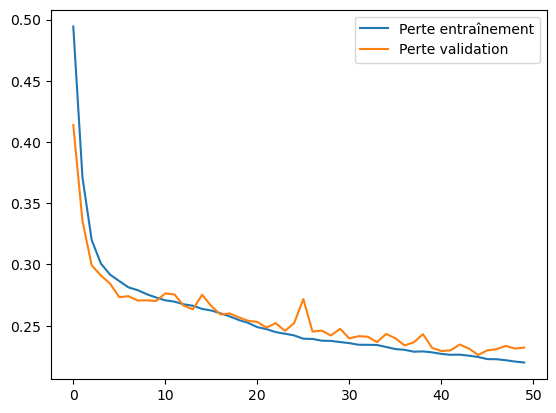

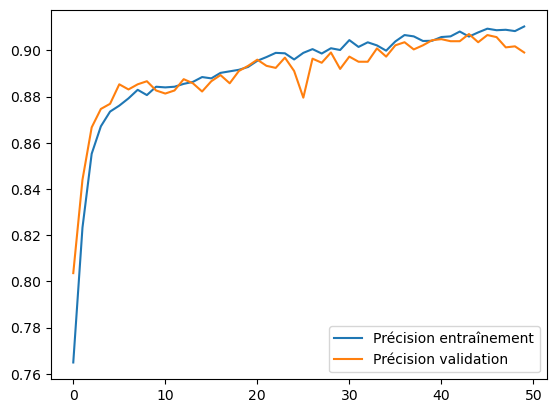

In [59]:
# Tracer la perte
print(history.history.keys())
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.legend()
plt.show()

# Tracer la précision
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.legend()
plt.show()

Evaluate the model

In [60]:
# Évaluer le modèle sur le jeu de test
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy of  test set: {accuracy:.2f}')

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8881 - loss: 0.2693
Accuracy of  test set: 0.90


5 - Conclusion

By observing the evolution of the loss function, we can see that there is no divergence, which means that there is neither overlearning nor underlearning. As a result, the model achieves 90% accuracy.

In [61]:
# print(loss)

### 6- KNeighborsClassifier

In [62]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_set, train_labels)
validation_predictions = knn.predict(validation_set)
test_predictions = knn.predict(test_set)

accuracy_val=accuracy_score(validation_labels,validation_predictions)
conf_matrix_val=confusion_matrix(validation_labels,validation_predictions)
classification_reg_val = classification_report(validation_labels,validation_predictions)
# test
accuracy_test=accuracy_score(test_labels,test_predictions)
conf_matrix_test=confusion_matrix(test_labels,test_predictions)
classification_reg_test = classification_report(test_labels,test_predictions)
#
print("accurcy of validation:", accuracy_val)
print("confusion matrix of validation:", conf_matrix_val)
print("classification of validation:",classification_reg_val)
#
print("accurcy of test:", accuracy_test)
print("confusion matrix of test:", conf_matrix_test)
print("classification of test:",classification_reg_test)

accurcy of validation: 0.8346666666666667
confusion matrix of validation: [[1316  157]
 [ 215  562]]
classification of validation:               precision    recall  f1-score   support

           0       0.86      0.89      0.88      1473
           1       0.78      0.72      0.75       777

    accuracy                           0.83      2250
   macro avg       0.82      0.81      0.81      2250
weighted avg       0.83      0.83      0.83      2250

accurcy of test: 0.8391111111111111
confusion matrix of test: [[1371  161]
 [ 201  517]]
classification of test:               precision    recall  f1-score   support

           0       0.87      0.89      0.88      1532
           1       0.76      0.72      0.74       718

    accuracy                           0.84      2250
   macro avg       0.82      0.81      0.81      2250
weighted avg       0.84      0.84      0.84      2250



#### Conclusion 6:

The k-NN model performs similarly on the validation and test sets, with an overall precision of around 83-84%. It classifies class 0 better (higher precision, recall and F1-score values) than class 1, which could indicate an imbalance or difficulty in correctly recognizing class 1. The model shows good generalizability, as performance is close between the validation and test sets.

## 7- GradientBoostingClassifier
###### *This algorithm builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss. Binary classification is a special case where only a single regression tree is induced.*

In [63]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(train_set, train_labels)
validation_predictions = gb.predict(validation_set)
test_predictions = gb.predict(test_set)


accuracy_val =accuracy_score(validation_labels,validation_predictions)
conf_matrix_val=confusion_matrix(validation_labels,validation_predictions)
classification_reg_val = classification_report(validation_labels,validation_predictions)

accuracy_test =accuracy_score(test_labels,test_predictions)
conf_matrix_test=confusion_matrix(test_labels,test_predictions)
classification_reg_test = classification_report(test_labels,test_predictions)

print("accurcy of validation", accuracy_val)
print("confusion matrix of validation:", conf_matrix_val)
print("classification of validation:",classification_reg_val )
#
print("accurcy of test", accuracy_test)
print("confusion matrix of test:", conf_matrix_test)
print("classification of test:",classification_reg_test )

accurcy of validation 0.9524444444444444
confusion matrix of validation: [[1429   44]
 [  63  714]]
classification of validation:               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1473
           1       0.94      0.92      0.93       777

    accuracy                           0.95      2250
   macro avg       0.95      0.94      0.95      2250
weighted avg       0.95      0.95      0.95      2250

accurcy of test 0.9426666666666667
confusion matrix of test: [[1474   58]
 [  71  647]]
classification of test:               precision    recall  f1-score   support

           0       0.95      0.96      0.96      1532
           1       0.92      0.90      0.91       718

    accuracy                           0.94      2250
   macro avg       0.94      0.93      0.93      2250
weighted avg       0.94      0.94      0.94      2250



#### Conclusion 7:
Gradient Boosting performs significantly better than the previous k-NN model. Overall accuracy exceeds 94% on both sets, with high F1 scores for both classes. The model also seems to generalize well, as results are consistent between validation and testing. Class 0 is still slightly better recognized than class 1, but the gap is reduced. This model seems more efficient and balanced.

## 8- Random forest

In [64]:

# Initialiser le Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle
rf.fit(train_set, train_labels)

# Prédictions et évaluation sur l'ensemble de validation
y_val_pred = rf.predict(validation_set)
val_accuracy = accuracy_score(validation_labels, y_val_pred)
print(f'Accuracy on validation set: {val_accuracy:.4f}')

# Prédictions et évaluation sur l'ensemble de test
y_test_pred = rf.predict(test_set)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy on test set: {test_accuracy:.4f}')

Accuracy on validation set: 0.9329
Accuracy on test set: 0.9338


## Final conclusion:
After several series of tests with different algorithms, we obtained the best result, achieving an accuracy of 95.24% in the prediction of the diabetic variable. However, the available variables do not provide a 100% explanation of the diabetic phenomenon, and we will restrict ourselves to the features provided.

Thus, the best-performing algorithm is a classifier, which is not surprising given that our problem was one of classification. The chosen model is therefore Gradient Boosting.

## Model saving

In [66]:
import joblib
#The best model
joblib.dump(gb, 'grandiantBoostingClassifier.pkl')
print("The model  saved !")


The model  saved !
